PyTorch UNet implementation using IceNet library for data download and post-processing of sea ice forecasting.

This notebook has been designed to be independent of other notebooks.

### Highlights
The key features of this notebook are:
* [1. Download](#1.-Download) 
* [2. Data Processing](#2.-Data-Processing)
* [3. Train](#3.-Train)
* [4. Prediction](#4.-Prediction)
* [5. Outputs and Plotting](#5.-Outputs-and-Plotting)

It currently uses a dev version of IceNet library (v0.2.8_dev) to run.

To install, can use the conda `icenet-notebooks/pytorch/environment.yml` environment file on a Linux system to be able to set-up the necessary pytorch + tensorflow + cuda + other modules which could be a tricky mix to get working manually:

```bash
conda env create -f environment.yml
```

### Contributions
#### PyTorch implementation of IceNet

Andrew McDonald ([icenet-gan](https://github.com/ampersandmcd/icenet-gan))

Bryn Noel Ubald (Refactor, updates for daily predictions and matching icenet library)

#### Notebook
Bryn Noel Ubald (author)

#### PyTorch Integration
Bryn Noel Ubald

Ryan Chan

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shutil
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader

# We also set the logging level so that we get some feedback from the API
import logging
logging.basicConfig(level=logging.INFO)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.set_float32_matmul_precision('medium')

JAX/FLAX imports

In [3]:
from flax.training import checkpoints, train_state
from flax import struct, serialization
import orbax.checkpoint

## 1. Download

In [4]:
from icenet.data.sic.mask import Masks
from icenet.data.interfaces.cds import ERA5Downloader
from icenet.data.sic.osisaf import SICDownloader

### Mask data

Create masks for masking data.

In [5]:
masks = Masks(north=False, south=True)
masks.generate(save_polarhole_masks=False)

INFO:root:siconca ice_conc_sh_ease2-250_cdr-v2p0_200001021200.nc already exists
INFO:root:Saving ./data/masks/south/masks/active_grid_cell_mask_01.npy
INFO:root:siconca ice_conc_sh_ease2-250_cdr-v2p0_200002021200.nc already exists
INFO:root:Saving ./data/masks/south/masks/active_grid_cell_mask_02.npy
INFO:root:siconca ice_conc_sh_ease2-250_cdr-v2p0_200003021200.nc already exists
INFO:root:Saving ./data/masks/south/masks/active_grid_cell_mask_03.npy
INFO:root:siconca ice_conc_sh_ease2-250_cdr-v2p0_200004021200.nc already exists
INFO:root:Saving ./data/masks/south/masks/active_grid_cell_mask_04.npy
INFO:root:siconca ice_conc_sh_ease2-250_cdr-v2p0_200005021200.nc already exists
INFO:root:Saving ./data/masks/south/masks/active_grid_cell_mask_05.npy
INFO:root:siconca ice_conc_sh_ease2-250_cdr-v2p0_200006021200.nc already exists
INFO:root:Saving ./data/masks/south/masks/active_grid_cell_mask_06.npy
INFO:root:siconca ice_conc_sh_ease2-250_cdr-v2p0_200007021200.nc already exists
INFO:root:Savi

### Climate and Sea Ice data

Download climate variables from ERA5 and sea ice concentration from OSI-SAF.

In [6]:
era5 = ERA5Downloader(
    var_names=["tas", "zg", "uas", "vas"],
    levels=[None, [250, 500], None, None],
    dates=[pd.to_datetime(date).date() for date in
           pd.date_range("2020-01-01", "2020-04-30", freq="D")],
    delete_tempfiles=False,
    max_threads=64,
    north=False,
    south=True,
    # NOTE: there appears to be a bug with the toolbox API at present (icenet#54)
    use_toolbox=False
)

era5.download()

INFO:root:Upping connection limit for max_threads > 10
INFO:root:Building request(s), downloading and daily averaging from ERA5 API
INFO:root:Processing single download for tas @ None with 121 dates
INFO:root:Processing single download for zg @ 250 with 121 dates
INFO:root:Processing single download for zg @ 500 with 121 dates
INFO:root:Processing single download for uas @ None with 121 dates
INFO:root:Processing single download for vas @ None with 121 dates
INFO:root:No requested dates remain, likely already present
INFO:root:No requested dates remain, likely already present
INFO:root:No requested dates remain, likely already present
INFO:root:No requested dates remain, likely already present
INFO:root:No requested dates remain, likely already present
INFO:root:0 daily files downloaded


In [7]:
sic = SICDownloader(
    dates=[pd.to_datetime(date).date() for date in
           pd.date_range("2020-01-01", "2020-04-30", freq="D")],
    delete_tempfiles=False,
    north=False,
    south=True,
    parallel_opens=False,
)

sic.download()

INFO:root:Downloading SIC datafiles to .temp intermediates...
INFO:root:Excluding 121 dates already existing from 121 dates requested.
INFO:root:Opening for interpolation: ['./data/osisaf/south/siconca/2020.nc']
INFO:root:Processing 0 missing dates


Re-grid ERA5 reanalysis data, and rotate wind vector data from ERA5 to align with EASE2 projection.

In [8]:
era5.regrid()
era5.rotate_wind_data()

INFO:root:No regrid batches to processing, moving on...
INFO:root:Rotating wind data prior to merging
/data/hpcdata/users/bryald/miniconda3/envs/pytfjax/lib/python3.11/site-packages/iris/__init__.py:354: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  cubes = _load_collection(uris, constraints, callback).cubes()
INFO:root:Rotating wind data in ./data/era5/south/uas ./data/era5/south/vas
INFO:root:0 files for uas
INFO:root:0 files for vas
INFO:root:Rotating wind data in ./data/era5/south/uas ./data/era5/south/vas
INFO:root:0 files for uas
INFO:root:0 files for vas


## 2. Data Processing

Process downloaded datasets.

To make life easier, setting up train, val, test dates.

In [9]:
processing_dates = dict(
    train=[pd.to_datetime(el) for el in pd.date_range("2020-01-01", "2020-03-31")],
    val=[pd.to_datetime(el) for el in pd.date_range("2020-04-03", "2020-04-23")],
    test=[pd.to_datetime(el) for el in pd.date_range("2020-04-01", "2020-04-02")],
)
processed_name = "notebook_api_jax_data"

In [10]:
processing_dates["test"]

[Timestamp('2020-04-01 00:00:00'), Timestamp('2020-04-02 00:00:00')]

Next, we create the data producer and configure them for the dataset we want to create.

In [11]:
from icenet.data.processors.era5 import IceNetERA5PreProcessor
from icenet.data.processors.meta import IceNetMetaPreProcessor
from icenet.data.processors.osi import IceNetOSIPreProcessor

pp = IceNetERA5PreProcessor(
    ["uas", "vas"],
    ["tas", "zg500", "zg250"],
    processed_name,
    processing_dates["train"],
    processing_dates["val"],
    processing_dates["test"],
    linear_trends=tuple(),
    north=False,
    south=True
)

osi = IceNetOSIPreProcessor(
    ["siconca"],
    [],
    processed_name,
    processing_dates["train"],
    processing_dates["val"],
    processing_dates["test"],
    linear_trends=tuple(),
    north=False,
    south=True
)

meta = IceNetMetaPreProcessor(
    processed_name,
    north=False,
    south=True
)

Next, we initialise the data processors using `init_source_data` which scans the data source directories to understand what data is available for processing based on the parameters. Since we named the processed data `"notebook_api_data"` above, it will create a data loader config file, `loader.notebook_api_data.json`, in the current directory.

In [12]:
pp.init_source_data(
    lag_days=1,
)
pp.process()

osi.init_source_data(
    lag_days=1,
)
osi.process()

meta.process()

INFO:root:Processing 91 dates for train category
INFO:root:Including lag of 1 days
INFO:root:Including lead of 93 days
INFO:root:No data found for 2019-12-31, outside data boundary perhaps?
INFO:root:Processing 21 dates for val category
INFO:root:Including lag of 1 days
INFO:root:Including lead of 93 days
INFO:root:Processing 2 dates for test category
INFO:root:Including lag of 1 days
INFO:root:Including lead of 93 days
INFO:root:Got 1 files for tas
INFO:root:Got 1 files for uas
INFO:root:Got 1 files for vas
INFO:root:Got 1 files for zg250
INFO:root:Got 1 files for zg500
INFO:root:Opening files for uas
INFO:root:Filtered to 121 units long based on configuration requirements
INFO:root:Normalising uas
INFO:root:Opening files for vas
INFO:root:Filtered to 121 units long based on configuration requirements
INFO:root:Normalising vas
INFO:root:Opening files for tas
INFO:root:Filtered to 121 units long based on configuration requirements
INFO:root:Reusing climatology ./processed/notebook_api_

At this point the preprocessed data is ready to convert or create a configuration for the network dataset.

### Dataset creation

As with the `icenet_dataset_create` command we can create a dataset configuration for training the network. As before this can include cached data for the network in the format of a TFRecordDataset compatible set of tfrecords. To achieve this we create the `IceNetDataLoader`, which can both generate `IceNetDataSet` configurations (which easily provide the necessary functionality for training and prediction) as well as individual data samples for direct usage.

In [13]:
from icenet.data.loaders import IceNetDataLoaderFactory

implementation = "dask"
loader_config = "loader.notebook_api_jax_data.json"
dataset_name = "notebook_api_jax_data"
lag = 1

dl = IceNetDataLoaderFactory().create_data_loader(
    implementation,
    loader_config,
    dataset_name,
    lag,
    n_forecast_days=7,
    north=False,
    south=True,
    output_batch_size=1,
    generate_workers=4)

INFO:root:Loading configuration loader.notebook_api_jax_data.json


At this point we can either use `generate` or `write_dataset_config_only` to produce a ready-to-go `IceNetDataSet` configuration. Both of these will generate a dataset config, `dataset_config.notebook_api_pytorch_data.json` (recall we set the dataset name as `notebook_api_pytorch_data` above).

In this case, for pytorch, will read data in directly, rather than using cached tfrecords inputs.

In [14]:
dl.write_dataset_config_only()

INFO:root:Writing dataset configuration without data generation
INFO:root:91 train dates in total, NOT generating cache data.
INFO:root:21 val dates in total, NOT generating cache data.
INFO:root:2 test dates in total, NOT generating cache data.
INFO:root:Writing configuration to ./dataset_config.notebook_api_jax_data.json


We can now create the IceNetDataSet object:

In [15]:
from icenet.data.dataset import IceNetDataSetPyTorch
dataset_config = f"dataset_config.{dataset_name}.json"

In [16]:
batch_size = 4
shuffle = False
persistent_workers=True
num_workers = 4

Create a dataloader interface for Jax from Pytorch.

In [17]:
import jax.numpy as jnp
from jax.tree_util import tree_map
from torch.utils import data

def numpy_collate(batch):
  return tree_map(np.asarray, data.default_collate(batch))

class NumpyDataLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32))

## 3. Train

We implement a custom PyTorch class for training.

## Create dataloader

In [18]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

In [19]:
# configure datasets and dataloaders
train_dataset = IceNetDataSetPyTorch(configuration_path=dataset_config, mode="train")
val_dataset = IceNetDataSetPyTorch(configuration_path=dataset_config, mode="val")
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers,
                                persistent_workers=persistent_workers, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers,
                            persistent_workers=persistent_workers, shuffle=False)

test_dataset = IceNetDataSetPyTorch(configuration_path=dataset_config, mode="test")
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers,
                            persistent_workers=persistent_workers, shuffle=False)

# Get number of channels (variables)
# Needed to initialise training state and abstract_ckpt (for prediction with checkpointing)
num_channels = train_dataset._config["num_channels"]

INFO:root:Loading configuration dataset_config.notebook_api_jax_data.json
INFO:root:Loading configuration /data/hpcdata/users/bryald/git/icenet/icenet-notebooks/jax/loader.notebook_api_jax_data.json
INFO:root:Loading configuration dataset_config.notebook_api_jax_data.json
INFO:root:Loading configuration /data/hpcdata/users/bryald/git/icenet/icenet-notebooks/jax/loader.notebook_api_jax_data.json
INFO:root:Loading configuration dataset_config.notebook_api_jax_data.json
INFO:root:Loading configuration /data/hpcdata/users/bryald/git/icenet/icenet-notebooks/jax/loader.notebook_api_jax_data.json


# IceNet UNet model

In [20]:
import jax
from flax import linen as nn
from jax.image import resize

class UNet(nn.Module):
    """UNet implementation for binary classification for IceNet"""

    padding = "SAME"
    filter_size = (3, 3)
    n_filters_factor = 0.1
    n_forecast_days = 7
    # kernel_init = nn.initializers.he_normal()
    # kernel_init(jax.random.key(42), (3, 3), jnp.float32)

    @nn.compact
    def __call__(self, x, train=True):
        """Forward pass"""
        filter_size = self.filter_size
        n_filters_factor = self.n_filters_factor
        n_forecast_days = self.n_forecast_days

        start_out_channels = 64
        reduced_channels = int(start_out_channels * n_filters_factor)
        channels = {
            start_out_channels * 2**pow: reduced_channels * 2**pow
            for pow in range(4)
        }
        
        conv1 = nn.Conv(channels[64], kernel_size=filter_size, padding=self.padding)(x)
        conv1 = nn.relu(conv1)
        conv1 = nn.Conv(channels[64], kernel_size=filter_size, padding=self.padding)(conv1)
        conv1 = nn.relu(conv1)
        bn1 = nn.BatchNorm(use_running_average=not train)(conv1)
        pool1 = nn.max_pool(bn1, window_shape=(2, 2), strides=(2, 2))
        
        conv2 = nn.Conv(channels[128], kernel_size=filter_size, padding=self.padding,)(pool1)
        conv2 = nn.relu(conv2)
        conv2 = nn.Conv(channels[128], kernel_size=filter_size, padding=self.padding,)(conv2)
        conv2 = nn.relu(conv2)
        bn2 = nn.BatchNorm(use_running_average=not train)(conv2)
        pool2 = nn.max_pool(bn2, window_shape=(2, 2), strides=(2, 2))

        conv3 = nn.Conv(channels[256], kernel_size=filter_size, padding=self.padding,)(pool2)
        conv3 = nn.relu(conv3)
        conv3 = nn.Conv(channels[256], kernel_size=filter_size, padding=self.padding,)(conv3)
        conv3 = nn.relu(conv3)
        bn3 = nn.BatchNorm(use_running_average=not train)(conv3)
        pool3 = nn.max_pool(bn3, window_shape=(2, 2), strides=(2, 2))

        conv4 = nn.Conv(channels[256], kernel_size=filter_size, padding=self.padding,)(pool3)
        conv4 = nn.relu(conv4)
        conv4 = nn.Conv(channels[256], kernel_size=filter_size, padding=self.padding,)(conv4)
        conv4 = nn.relu(conv4)
        bn4 = nn.BatchNorm(use_running_average=not train)(conv4)
        pool4 = nn.max_pool(bn4, window_shape=(2, 2), strides=(2, 2))

        conv5 = nn.Conv(channels[512], kernel_size=filter_size, padding=self.padding,)(pool4)
        conv5 = nn.relu(conv5)
        conv5 = nn.Conv(channels[512], kernel_size=filter_size, padding=self.padding,)(conv5)
        conv5 = nn.relu(conv5)
        bn5 = nn.BatchNorm(use_running_average=not train)(conv5)

        bn5 = resize(bn5, shape=(bn5.shape[0], bn5.shape[1]*2, bn5.shape[2]*2, bn5.shape[3]), method="nearest")
        up6 = nn.Conv(channels[256], kernel_size=(2, 2), padding=self.padding,)(bn5)
        merge6 = jnp.concatenate([bn4, up6], axis=-1)
        conv6 = nn.Conv(channels[256], kernel_size=filter_size, padding=self.padding,)(merge6)
        conv6 = nn.relu(conv6)
        conv6 = nn.Conv(channels[256], kernel_size=filter_size, padding=self.padding,)(conv6)
        conv6 = nn.relu(conv6)
        bn6 = nn.BatchNorm(use_running_average=not train)(conv6)

        bn6 = resize(bn6, shape=(bn6.shape[0], bn6.shape[1]*2, bn6.shape[2]*2, bn6.shape[3]), method="nearest")
        up7 = nn.Conv(channels[256], kernel_size=(2, 2), padding=self.padding,)(bn6)
        merge7 = jnp.concatenate([bn3, up7], axis=-1)
        conv7 = nn.Conv(channels[256], kernel_size=filter_size, padding=self.padding,)(merge7)
        conv7 = nn.relu(conv7)
        conv7 = nn.Conv(channels[256], kernel_size=filter_size, padding=self.padding,)(conv7)
        conv7 = nn.relu(conv7)
        bn7 = nn.BatchNorm(use_running_average=not train)(conv7)

        bn7 = resize(bn7, shape=(bn7.shape[0], bn7.shape[1]*2, bn7.shape[2]*2, bn7.shape[3]), method="nearest")
        up8 = nn.Conv(channels[128], kernel_size=(2, 2), padding=self.padding,)(bn7)
        merge8 = jnp.concatenate([bn2, up8], axis=-1)
        conv8 = nn.Conv(channels[128], kernel_size=filter_size, padding=self.padding,)(merge8)
        conv8 = nn.relu(conv8)
        conv8 = nn.Conv(channels[128], kernel_size=filter_size, padding=self.padding,)(conv8)
        conv8 = nn.relu(conv8)
        bn8 = nn.BatchNorm(use_running_average=not train)(conv8)

        bn8 = resize(bn8, shape=(bn8.shape[0], bn8.shape[1]*2, bn8.shape[2]*2, bn8.shape[3]), method="nearest")
        up9 = nn.Conv(channels[64], kernel_size=(2, 2), padding=self.padding,)(bn8)
        merge9 = jnp.concatenate([bn1, up9], axis=-1)

        conv9 = nn.Conv(channels[64], kernel_size=filter_size, padding=self.padding,)(merge9)
        conv9 = nn.Conv(channels[64], kernel_size=filter_size, padding=self.padding,)(conv9)
        conv9 = nn.Conv(channels[64], kernel_size=filter_size, padding=self.padding,)(conv9)

        final_layer = nn.Conv(n_forecast_days, kernel_size=(1, 1),)(conv9)

        # if not train:
        #     return nn.sigmoid(final_layer)
        return final_layer

### View model layer

In [21]:
import jax
import jax.numpy as jnp  # JAX NumPy

unet = UNet()
print(unet.tabulate(jax.random.key(0), jnp.ones((1, 432, 432, 9)),
                   train=True))

# Newer flax version (>0.8.0)
# print(unet.tabulate(jax.random.key(0), jnp.ones((1, 432, 432, 9)),
#                    train=True,
#                    compute_flops=True, compute_vjp_flops=True))

I0000 00:00:1711493252.150729   23358 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory



                                  UNet Summary                                  
┏━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ path       ┃ module    ┃ inputs      ┃ outputs    ┃ batch_stats ┃ params     ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│            │ UNet      │ -           │ float32[1… │             │            │
│            │           │ float32[1,… │            │             │            │
│            │           │ - train:    │            │             │            │
│            │           │ True        │            │             │            │
├────────────┼───────────┼─────────────┼────────────┼─────────────┼────────────┤
│ Conv_0     │ Conv      │ float32[1,… │ float32[1… │             │ bias:      │
│            │           │             │            │             │ float32[6] │
│            │           │             │            │             │ kernel:    │
│            │           │ 

# 3. Train

In [22]:
from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers

### Define custom metrics

In [23]:
@struct.dataclass
class BinaryAccuracy(metrics.Metric):
    weighted_score: jnp.ndarray
    possible_score: jnp.ndarray

    @classmethod
    def empty(cls):
        return cls(weighted_score=jnp.array(0, jnp.float32), possible_score=jnp.array(0, jnp.int32))

    @classmethod
    def from_model_output(cls, *, predictions, targets, sample_weights, **kwargs):
        predictions = predictions > 0.15
        targets = targets > 0.15
        base_score = predictions == targets
        return cls(
            weighted_score = jnp.sum(base_score*sample_weights),
            possible_score = jnp.sum(sample_weights)
        )

    def compute(self):
        binary_accuracy = self.weighted_score / self.possible_score * 100
        return binary_accuracy

@struct.dataclass
class RMSE(metrics.Metric):
    rmse: float

    @classmethod
    def empty(cls):
        return cls(rmse=0.)

    @classmethod
    def from_model_output(cls, *, predictions, targets, sample_weights, **kwargs):
        predictions = 100*(predictions > 0.15)*sample_weights
        targets = 100*(targets > 0.15)*sample_weights
        rmse = jnp.sqrt(jnp.mean(jnp.square(predictions - targets)))
        return cls(
            rmse = rmse
        )

    def compute(self):
        return self.rmse

In [24]:
@struct.dataclass
class Metrics(metrics.Collection):
  # accuracy: metrics.Accuracy
  accuracy: BinaryAccuracy
  rmse : RMSE
  loss: metrics.Average.from_output('loss')

## Define training state

In [25]:
class TrainState(train_state.TrainState):
  # Ref: https://flax.readthedocs.io/en/latest/guides/training_techniques/batch_norm.html#training-and-evaluation
  batch_stats: any
  metrics: Metrics

def create_train_state(module, rng, learning_rate, momentum):
  """Creates an initial `TrainState`."""
  variables = module.init(rng, jnp.ones([1, 432, 432, num_channels]), train=False) # initialize parameters by passing a template image
  params = variables['params'] # initialize parameters by passing a template image
  batch_stats = variables['batch_stats']
  tx = optax.sgd(learning_rate, momentum)
  return TrainState.create(
      apply_fn=module.apply,
      params=params,
      batch_stats=batch_stats,
      tx=tx,
      metrics=Metrics.empty()
      )

## Define training step

In [26]:
@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  inputs, targets, sample_weights = batch
  def loss_fn(params):
    # Ref: https://flax.readthedocs.io/en/latest/guides/training_techniques/batch_norm.html#training-and-evaluation
    logits, updates = state.apply_fn(
      {'params': params, 'batch_stats': state.batch_stats},
      x=inputs,
      train=True,
      mutable=['batch_stats']
      )
    batch_stats = updates['batch_stats']
    # loss = optax.softmax_cross_entropy_with_integer_labels(
    #     logits=logits, labels=batch['label']).mean()
    # print("Checking shapes:", logits.shape, targets.shape, sample_weights.shape)
    loss = optax.l2_loss(100*nn.sigmoid(logits)*sample_weights, 100*targets*sample_weights).mean()
    return loss, (logits, updates)
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, (logits, updates)), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  state = state.replace(batch_stats=updates['batch_stats'])

  # preds = nn.sigmoid(logits) > 0.15
  # targets = targets > 0.15
  # base_score = preds == targets
  # weighted_score = jnp.sum(base_score*sample_weights)
  # possible_score = jnp.sum(sample_weights)
  # metrics = {
  #   'loss': loss,
  #   'binary_accuracy': weighted_score / possible_score * 100
  # }
  return state#, metrics

## Metric computaton

In [27]:
@jax.jit
def compute_metrics(*, state, batch):
  inputs, targets, sample_weights = batch
  # Ref: https://flax.readthedocs.io/en/latest/guides/training_techniques/batch_norm.html#training-and-evaluation
  logits, updates = state.apply_fn(
    {'params': state.params, 'batch_stats': state.batch_stats},
    x=inputs,
    train=True,
    mutable=['batch_stats']
    )
  batch_stats = updates['batch_stats']
#   loss = optax.softmax_cross_entropy_with_integer_labels(
#         logits=logits, labels=batch['label']).mean()
  loss = optax.l2_loss(
    predictions=100*nn.sigmoid(logits)*sample_weights,
    targets=100*targets*sample_weights
    ).mean()
  
  metric_updates = state.metrics.single_from_model_output(
    predictions=nn.sigmoid(logits)*sample_weights, targets=targets*sample_weights, sample_weights=sample_weights, loss=loss)
  state = state.replace(metrics=metric_updates)
  # metrics = state.metrics.merge(metric_updates)
  # state = state.replace(metrics=metrics)


  # preds = nn.sigmoid(logits) > 0.15
  # targets = targets > 0.15
  # base_score = preds == targets
  # weighted_score = jnp.sum(base_score*sample_weights)
  # possible_score = jnp.sum(sample_weights)
  # metrics = {
  #   'loss': loss,
  #   'accuracy': weighted_score / possible_score * 100
  # }
  # state = state.replace(metrics=metrics)
  return state

## Define data

In [28]:
num_epochs = 10

## Set seed randomness

In [29]:
import tensorflow as tf

tf.random.set_seed(0)
init_rng = jax.random.key(0)

## Initialize the `TrainState`

In [30]:
learning_rate = 1e-4
momentum = 0.9

In [31]:
state = create_train_state(unet, init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

# Train and evaluate

In [32]:
import math
num_steps_per_epoch = math.ceil(len(processing_dates["train"]) / batch_size)
num_steps_per_epoch

23

Initialise metrics history and checkpointing

In [33]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'train_rmse': [],
                   'val_loss': [],
                   'val_accuracy': [],
                   'val_rmse': []
                   }

In [34]:
ckpt_dir = '/tmp/flax_ckpt'

if os.path.exists(ckpt_dir):
    shutil.rmtree(ckpt_dir)  # Remove any existing checkpoints from the last notebook run.

In [35]:
from flax.training import orbax_utils

# orbax_checkpointer = orbax.checkpoint.AsyncCheckpointer(orbax.checkpoint.PyTreeCheckpointHandler())
# # options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=4, create=True, best_fn=lambda metrics: metrics["val_rmse"], best_mode="min")
# options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=4, create=True)
# out_path = os.path.abspath('managed-checkpoint')
# checkpoint_manager = orbax.checkpoint.CheckpointManager(out_path, options=options)

options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=1, create=True, best_fn=lambda metrics: metrics, best_mode='min')
checkpoint_manager = orbax.checkpoint.CheckpointManager('/tmp/flax_ckpt/orbax/managed', options=options)


for epoch in range(1, num_epochs+1):
  for step, batch in enumerate(train_dataloader):

    # Convert to numpy
    batch = [element.numpy()[..., 0] if element.shape[-1] == 1 else element.numpy() for element in batch]
    # batch[0] = jnp.expand_dims(batch[0], axis=-1)
    # print("Init shapes", batch[0].shape, batch[1].shape, batch[2].shape)

    # Run optimization steps over training batches and compute batch metrics
    state = train_step(state, batch) # get updated train state (which contains the updated parameters)
    state = compute_metrics(state=state, batch=batch) # aggregate batch metrics

    # print(f"Step: {step+1}, num_steps_per_epoch: {num_steps_per_epoch}, check: {(step+1) % num_steps_per_epoch}")
    if (step+1) % num_steps_per_epoch == 0: # one training epoch has passed
      print("\tRunning validation set")
      for metric,value in state.metrics.compute().items(): # compute metrics
        metrics_history[f'train_{metric}'].append(value) # record metrics
      # state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

      # Compute metrics on the validation set after each training epoch
      val_state = state
      for val_batch in val_dataloader:
        # print("Val shapes", val_batch[0].shape, val_batch[1].shape, val_batch[2].shape)
        val_batch = [element.numpy()[..., 0] if element.shape[-1] == 1 else element.numpy() for element in val_batch]
        # print("Val shapes", val_batch[0].shape, val_batch[1].shape, val_batch[2].shape)
        val_state = compute_metrics(state=val_state, batch=val_batch)

      for metric,value in val_state.metrics.compute().items():
        metrics_history[f'val_{metric}'].append(value)

      print(f"train epoch: {(epoch)}, "
            f"loss: {metrics_history['train_loss'][-1]}, "
            f"accuracy: {metrics_history['train_accuracy'][-1]}, "
            f"rmse: {metrics_history['train_rmse'][-1]}"
            )
      print(f"val epoch: {(epoch)}, "
            f"loss: {metrics_history['val_loss'][-1]}, "
            f"accuracy: {metrics_history['val_accuracy'][-1]}, "
            f"rmse: {metrics_history['val_rmse'][-1]}"
            )

      print("Checkpointing...")
      # Bundle everything together.
      ckpt = {'model': state}
      # save_args = orbax_utils.save_args_from_target(ckpt)
      save_args = orbax.checkpoint.args.StandardSave(state)
      # orbax_checkpointer.save('/tmp/flax_ckpt/orbax/single_save', ckpt, save_args=save_args, force=True)
      val_rmse = state.metrics.rmse.rmse.item()
      # checkpoint_manager.save(epoch, save_kwargs={'save_args': save_args}, metrics=val_rmse)
      checkpoint_manager.save(epoch, args=save_args, metrics=val_rmse)
      
      state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch








#       # Bundle everything together.
#       ckpt = {'model': state}
#       save_args = orbax_utils.save_args_from_target(ckpt)
#       checkpoint_manager.save(step, ckpt, save_kwargs={'save_args': save_args}, force=True)






#       # print(type(state))
#       # # state['step'] = step
#       # state_save_args = jax.tree_map(lambda _: orbax.checkpoint.SaveArgs(), state)
#       # # print(state)
#       # # checkpoint_manager.save(step, state, metrics=state.metrics)
#       # checkpoint_manager.save(
#       #   step,
#       #   # # {
#       #   # #   "model_state": state,
#       #   # # }
#       #   # # metrics=state.metrics
#       #   # items={
#       #   #     'state': state,
#       #   # },
#       #   # # save_kwargs must be a dict with the same keys as items.
#       #   # # not all keys in items have to be provided, in which case default kwargs
#       #   # # are used each value must be a dict with keyword args passed to the
#       #   # # underlying CheckpointHandler for that item (see CheckpointManager
#       #   # # object construction)
#       #   # save_kwargs={'state': {
#       #   #     'save_args': state_save_args
#       #   # }},
#       #   )

#       state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

checkpoint_manager.wait_until_finished()
print(f'Checkpointed epochs: {checkpoint_manager.all_steps()}')

INFO:absl:Using timeout: 300 secs and primary_host=0 for async checkpoint writes
INFO:absl:Found 0 checkpoint steps in /tmp/flax_ckpt/orbax/managed
INFO:absl:jax.process_index=0, primary_host=0. CheckpointManager created: <orbax.checkpoint.checkpoint_manager.CheckpointManager object at 0x7f79d086d2d0>


	Running validation set


INFO:absl:Commit thread error check finished successfully
INFO:absl:Async saving item to /tmp/flax_ckpt/orbax/managed/1.


train epoch: 1, loss: 25.900915145874023, accuracy: 93.80838775634766, rmse: 11.701366424560547
val epoch: 1, loss: 28.466548919677734, accuracy: 92.90042114257812, rmse: 12.107010841369629
Checkpointing...


INFO:absl:Starting commit to storage layer by process: 0
INFO:absl:Beginning async checkpoint finalize.
INFO:absl:Finished committing to storage layer by process: 0
INFO:absl:Renaming /tmp/flax_ckpt/orbax/managed/1.orbax-checkpoint-tmp-1711493383509316 to /tmp/flax_ckpt/orbax/managed/1
INFO:absl:Finished saving checkpoint to `/tmp/flax_ckpt/orbax/managed/1`.
INFO:absl:Commit thread joined successfully
INFO:absl:Commit thread error check finished successfully


	Running validation set


INFO:absl:Commit thread error check finished successfully
INFO:absl:Async saving item to /tmp/flax_ckpt/orbax/managed/2.
INFO:absl:Starting commit to storage layer by process: 0
INFO:absl:Finished committing to storage layer by process: 0
INFO:absl:Deleting Checkpoint[step=2 | time=2024-03-26 22:49:51.222925+00:00]: (Reason: worse metric).


train epoch: 2, loss: 23.892532348632812, accuracy: 93.77287292480469, rmse: 11.734354019165039
val epoch: 2, loss: 27.17943572998047, accuracy: 92.83394622802734, rmse: 12.163552284240723
Checkpointing...


INFO:absl:Beginning async checkpoint finalize.
INFO:absl:Renaming /tmp/flax_ckpt/orbax/managed/2.orbax-checkpoint-tmp-1711493391042900 to /tmp/flax_ckpt/orbax/managed/2
INFO:absl:Finished saving checkpoint to `/tmp/flax_ckpt/orbax/managed/2`.
INFO:absl:Commit thread joined successfully
INFO:absl:Commit thread error check finished successfully
INFO:absl:Deleted step 2.


	Running validation set


INFO:absl:Commit thread error check finished successfully
INFO:absl:Async saving item to /tmp/flax_ckpt/orbax/managed/3.
INFO:absl:Starting commit to storage layer by process: 0
INFO:absl:Deleting Checkpoint[step=1 | time=2024-03-26 22:49:44.456831+00:00]: (Reason: worse metric).
INFO:absl:Beginning async checkpoint finalize.
INFO:absl:Finished committing to storage layer by process: 0
INFO:absl:Renaming /tmp/flax_ckpt/orbax/managed/3.orbax-checkpoint-tmp-1711493397664144 to /tmp/flax_ckpt/orbax/managed/3
INFO:absl:Finished saving checkpoint to `/tmp/flax_ckpt/orbax/managed/3`.
INFO:absl:Commit thread joined successfully
INFO:absl:Commit thread error check finished successfully


train epoch: 3, loss: 12.259121894836426, accuracy: 95.6865463256836, rmse: 9.69345760345459
val epoch: 3, loss: 18.535686492919922, accuracy: 94.64530944824219, rmse: 10.514480590820312
Checkpointing...


INFO:absl:Deleted step 1.


	Running validation set


INFO:absl:Commit thread error check finished successfully
INFO:absl:Async saving item to /tmp/flax_ckpt/orbax/managed/4.
INFO:absl:Starting commit to storage layer by process: 0
INFO:absl:Finished committing to storage layer by process: 0
INFO:absl:Deleting Checkpoint[step=3 | time=2024-03-26 22:49:57.820349+00:00]: (Reason: worse metric).
INFO:absl:Beginning async checkpoint finalize.


train epoch: 4, loss: 7.809539794921875, accuracy: 96.50248718261719, rmse: 8.81944751739502
val epoch: 4, loss: 12.563033103942871, accuracy: 96.15970611572266, rmse: 8.904353141784668
Checkpointing...


INFO:absl:Renaming /tmp/flax_ckpt/orbax/managed/4.orbax-checkpoint-tmp-1711493404695263 to /tmp/flax_ckpt/orbax/managed/4
INFO:absl:Finished saving checkpoint to `/tmp/flax_ckpt/orbax/managed/4`.
INFO:absl:Commit thread joined successfully
INFO:absl:Commit thread error check finished successfully
INFO:absl:Deleted step 3.


	Running validation set


INFO:absl:Commit thread error check finished successfully
INFO:absl:Async saving item to /tmp/flax_ckpt/orbax/managed/5.
INFO:absl:Starting commit to storage layer by process: 0
INFO:absl:Deleting Checkpoint[step=4 | time=2024-03-26 22:50:04.872620+00:00]: (Reason: worse metric).
INFO:absl:Finished committing to storage layer by process: 0
INFO:absl:Beginning async checkpoint finalize.
INFO:absl:Renaming /tmp/flax_ckpt/orbax/managed/5.orbax-checkpoint-tmp-1711493411431406 to /tmp/flax_ckpt/orbax/managed/5
INFO:absl:Finished saving checkpoint to `/tmp/flax_ckpt/orbax/managed/5`.


train epoch: 5, loss: 6.929506301879883, accuracy: 96.96492004394531, rmse: 8.167764663696289
val epoch: 5, loss: 12.246231079101562, accuracy: 96.29217529296875, rmse: 8.749444007873535
Checkpointing...


INFO:absl:Commit thread joined successfully
INFO:absl:Commit thread error check finished successfully
INFO:absl:Deleted step 4.


	Running validation set


INFO:absl:Commit thread error check finished successfully
INFO:absl:Async saving item to /tmp/flax_ckpt/orbax/managed/6.
INFO:absl:Starting commit to storage layer by process: 0
INFO:absl:Deleting Checkpoint[step=5 | time=2024-03-26 22:50:11.599368+00:00]: (Reason: worse metric).
INFO:absl:Beginning async checkpoint finalize.
INFO:absl:Finished committing to storage layer by process: 0
INFO:absl:Renaming /tmp/flax_ckpt/orbax/managed/6.orbax-checkpoint-tmp-1711493418596130 to /tmp/flax_ckpt/orbax/managed/6
INFO:absl:Finished saving checkpoint to `/tmp/flax_ckpt/orbax/managed/6`.
INFO:absl:Commit thread joined successfully
INFO:absl:Commit thread error check finished successfully
INFO:absl:Deleted step 5.


train epoch: 6, loss: 6.409462928771973, accuracy: 97.04837036132812, rmse: 8.07727336883545
val epoch: 6, loss: 11.930301666259766, accuracy: 96.35050964355469, rmse: 8.680340766906738
Checkpointing...
	Running validation set


INFO:absl:Commit thread error check finished successfully
INFO:absl:Async saving item to /tmp/flax_ckpt/orbax/managed/7.
INFO:absl:Starting commit to storage layer by process: 0
INFO:absl:Finished committing to storage layer by process: 0
INFO:absl:Deleting Checkpoint[step=6 | time=2024-03-26 22:50:18.745705+00:00]: (Reason: worse metric).
INFO:absl:Beginning async checkpoint finalize.
INFO:absl:Renaming /tmp/flax_ckpt/orbax/managed/7.orbax-checkpoint-tmp-1711493425490424 to /tmp/flax_ckpt/orbax/managed/7
INFO:absl:Finished saving checkpoint to `/tmp/flax_ckpt/orbax/managed/7`.
INFO:absl:Commit thread joined successfully
INFO:absl:Commit thread error check finished successfully
INFO:absl:Deleted step 6.


train epoch: 7, loss: 6.595624923706055, accuracy: 97.28857421875, rmse: 7.68831205368042
val epoch: 7, loss: 13.50122356414795, accuracy: 96.25247955322266, rmse: 8.796147346496582
Checkpointing...
	Running validation set


INFO:absl:Commit thread error check finished successfully
INFO:absl:Async saving item to /tmp/flax_ckpt/orbax/managed/8.


train epoch: 8, loss: 6.432151794433594, accuracy: 97.40271759033203, rmse: 7.529146671295166
val epoch: 8, loss: 12.920607566833496, accuracy: 96.30125427246094, rmse: 8.738718032836914
Checkpointing...


INFO:absl:Starting commit to storage layer by process: 0
INFO:absl:Finished committing to storage layer by process: 0
INFO:absl:Deleting Checkpoint[step=7 | time=2024-03-26 22:50:25.651727+00:00]: (Reason: worse metric).
INFO:absl:Beginning async checkpoint finalize.
INFO:absl:Renaming /tmp/flax_ckpt/orbax/managed/8.orbax-checkpoint-tmp-1711493432091012 to /tmp/flax_ckpt/orbax/managed/8
INFO:absl:Finished saving checkpoint to `/tmp/flax_ckpt/orbax/managed/8`.
INFO:absl:Commit thread joined successfully
INFO:absl:Commit thread error check finished successfully
INFO:absl:Deleted step 7.


	Running validation set


INFO:absl:Commit thread error check finished successfully
INFO:absl:Async saving item to /tmp/flax_ckpt/orbax/managed/9.


train epoch: 9, loss: 5.449045181274414, accuracy: 97.49353790283203, rmse: 7.406649112701416
val epoch: 9, loss: 11.820505142211914, accuracy: 96.26969909667969, rmse: 8.775920867919922
Checkpointing...


INFO:absl:Starting commit to storage layer by process: 0
INFO:absl:Finished committing to storage layer by process: 0
INFO:absl:Deleting Checkpoint[step=8 | time=2024-03-26 22:50:32.326964+00:00]: (Reason: worse metric).
INFO:absl:Beginning async checkpoint finalize.
INFO:absl:Renaming /tmp/flax_ckpt/orbax/managed/9.orbax-checkpoint-tmp-1711493438829231 to /tmp/flax_ckpt/orbax/managed/9
INFO:absl:Finished saving checkpoint to `/tmp/flax_ckpt/orbax/managed/9`.
INFO:absl:Commit thread joined successfully
INFO:absl:Commit thread error check finished successfully
INFO:absl:Deleted step 8.


	Running validation set


INFO:absl:Commit thread error check finished successfully
INFO:absl:Async saving item to /tmp/flax_ckpt/orbax/managed/10.
INFO:absl:Starting commit to storage layer by process: 0


train epoch: 10, loss: 5.322022438049316, accuracy: 97.59054565429688, rmse: 7.251336097717285
val epoch: 10, loss: 12.634425163269043, accuracy: 96.24913024902344, rmse: 8.800074577331543
Checkpointing...


INFO:absl:Finished committing to storage layer by process: 0
INFO:absl:Deleting Checkpoint[step=9 | time=2024-03-26 22:50:39.023166+00:00]: (Reason: worse metric).
INFO:absl:Beginning async checkpoint finalize.
INFO:absl:Renaming /tmp/flax_ckpt/orbax/managed/10.orbax-checkpoint-tmp-1711493445539374 to /tmp/flax_ckpt/orbax/managed/10
INFO:absl:Finished saving checkpoint to `/tmp/flax_ckpt/orbax/managed/10`.
INFO:absl:Commit thread joined successfully
INFO:absl:Commit thread error check finished successfully
INFO:absl:Deleted step 9.


Checkpointed epochs: [10]


In [36]:
os.listdir('/tmp/flax_ckpt/orbax/managed')  # Because max_to_keep=2, only step 3 and 4 are retained

['10']

## 4. Prediction

Load latest saved checkpoint

In [37]:
checkpoint_manager.best_step()

10

In [38]:
save_args = orbax.checkpoint.args.StandardSave(state)

In [39]:
# Define an abstract train state which will be replaced with checkpoint data.
variables = unet.init(jax.random.key(0), jnp.ones([1, 432, 432, num_channels]), train=False)
abstract_ckpt = TrainState.create(apply_fn=unet.apply, params=variables["params"], tx=optax.sgd(0.1, 0.9), batch_stats=variables["batch_stats"], metrics=Metrics.empty())
restore_args = orbax.checkpoint.args.StandardRestore(abstract_ckpt)

epoch = checkpoint_manager.latest_step()
state_restored = checkpoint_manager.restore(epoch, args=restore_args)

INFO:absl:Commit thread error check finished successfully
INFO:absl:Restoring item from /tmp/flax_ckpt/orbax/managed/10.
INFO:absl:Finished restoring checkpoint from /tmp/flax_ckpt/orbax/managed/10.


In [40]:
type(state_restored)

__main__.TrainState

In [41]:
@jax.jit
def pred_step(state, batch):
  inputs, targets, sample_weights = batch
  logits, updates = state.apply_fn(
    {'params': state.params, 'batch_stats': state.batch_stats},
    x=inputs,
    train=False,
    mutable=['batch_stats']
    )
  return nn.sigmoid(logits)

predictions = []
for step, test_batch in enumerate(test_dataloader):
  print(f"Batch: {step}")
  # Convert to numpy
  test_batch = [element.numpy()[..., 0] if element.shape[-1] == 1 else element.numpy() for element in test_batch]
  pred = pred_step(state_restored, test_batch)
  predictions.append(pred)

Batch: 0


In [42]:
predictions[0].shape

(2, 432, 432, 7)

## 5. Outputs and Plotting

Create prediction output directory

In [43]:
# dataset = "pytorch_notebook"
network_name = "api_jax_dataset"
output_name = "example_jax_forecast"
output_folder = os.path.join(".", "results", "predict", output_name,
                                "{}.{}".format(network_name, 42))
os.makedirs(output_folder, exist_ok=output_folder)

Convert and output predictions to numpy files

In [44]:
idx = 0
for workers, prediction in enumerate(predictions):
    for batch in range(prediction.shape[0]):
        date = pd.Timestamp(test_dataset.dates[idx].replace('_', '-'))
        output_path = os.path.join(output_folder, date.strftime("%Y_%m_%d.npy"))
        forecast = prediction[batch, :, :, :]
        # # forecast_np = forecast.detach().cpu().numpy()
        np.save(output_path, forecast)
        idx += 1

Create a csv file with all the test dates we have predicted for, and to use in generating the final netCDF output using `icenet_output`.

In [45]:
!printf "2020-04-01\n2020-04-02" | tee testdates.csv

2020-04-01
2020-04-02

In [46]:
!icenet_output -m -o results/predict example_jax_forecast notebook_api_jax_data testdates.csv

[26-03-24 22:50:59 :INFO    ] - Loading configuration ./dataset_config.notebook_api_jax_data.json
[26-03-24 22:50:59 :WARNING ] - Running in configuration only mode, tfrecords were not generated for this dataset
/data/hpcdata/users/bryald/miniconda3/envs/pytfjax/lib/python3.11/site-packages/iris/__init__.py:354: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  cubes = _load_collection(uris, constraints, callback).cubes()
[26-03-24 22:50:59 :INFO    ] - Post-processing 2020-04-01
[26-03-24 22:50:59 :INFO    ] - Post-processing 2020-04-02
[26-03-24 22:50:59 :INFO    ] - Dataset arr shape: (2, 432, 432, 7, 2)
[26-03-24 22:50:59 :INFO    ] - Applying active grid cell masks
[26-03-24 22:51:00 :INFO    ] - Land masking the forecast output
[26-03-24 22:51:00 :INFO    ] - Applying zeros to land mask
[26-03-24 22:51:00 :INFO  

Plotting the forecast

In [47]:
import xarray as xr
import datetime as dt
from IPython.display import HTML

In [48]:
from icenet.plotting.video import xarray_to_video as xvid
from icenet.data.sic.mask import Masks

ds = xr.open_dataset("results/predict/example_jax_forecast.nc")
land_mask = Masks(south=True, north=False).get_land_mask()
ds.info()

xarray.Dataset {
dimensions:
	time = 2 ;
	yc = 432 ;
	xc = 432 ;
	leadtime = 7 ;

variables:
	int32 Lambert_Azimuthal_Grid() ;
		Lambert_Azimuthal_Grid:grid_mapping_name = lambert_azimuthal_equal_area ;
		Lambert_Azimuthal_Grid:longitude_of_projection_origin = 0.0 ;
		Lambert_Azimuthal_Grid:latitude_of_projection_origin = -90.0 ;
		Lambert_Azimuthal_Grid:false_easting = 0.0 ;
		Lambert_Azimuthal_Grid:false_northing = 0.0 ;
		Lambert_Azimuthal_Grid:semi_major_axis = 6378137.0 ;
		Lambert_Azimuthal_Grid:inverse_flattening = 298.257223563 ;
		Lambert_Azimuthal_Grid:proj4_string = +proj=laea +lon_0=0 +datum=WGS84 +ellps=WGS84 +lat_0=-90.0 ;
	float32 sic_mean(time, yc, xc, leadtime) ;
		sic_mean:long_name = mean sea ice area fraction across ensemble runs of icenet model ;
		sic_mean:standard_name = sea_ice_area_fraction ;
		sic_mean:short_name = sic ;
		sic_mean:valid_min = 0 ;
		sic_mean:valid_max = 1 ;
		sic_mean:ancillary_variables = sic_stddev ;
		sic_mean:grid_mapping = Lambert_Azimuth

In [49]:
forecast_date = ds.time.values[0]
fc = ds.sic_mean.isel(time=0).drop_vars("time").rename(dict(leadtime="time"))
fc['time'] = [pd.to_datetime(forecast_date) \
              + dt.timedelta(days=int(e)) for e in fc.time.values]

anim = xvid(fc, 15, figsize=4, mask=land_mask)
HTML(anim.to_jshtml())

INFO:root:Inspecting data
INFO:root:Initialising plot
INFO:root:Animating
INFO:root:Not saving plot, will return animation
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


___

#### Load original input dataset

This is the original input dataset (pre-normalisation) for comparison.

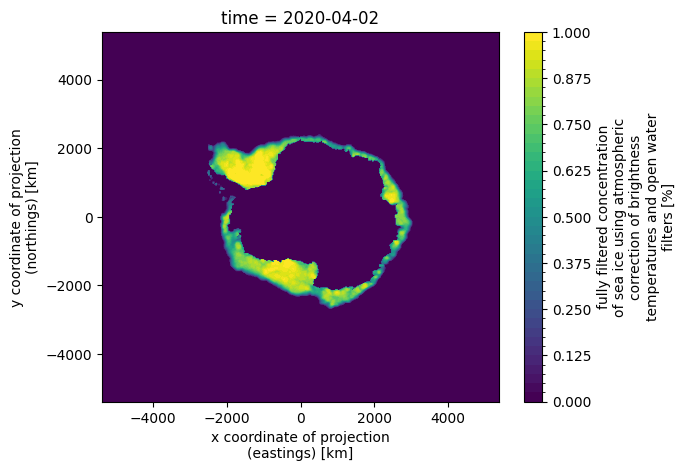

In [50]:
# Load original input dataset (domain not normalised)
xr.plot.contourf(xr.open_dataset("data/osisaf/south/siconca/2020.nc").isel(time=92).ice_conc, levels=50)

## Version
- IceNet Codebase: v0.2.8_dev